In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -q monai opencv-python scikit-image matplotlib nibabel


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 64.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 28.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

from monai.networks.nets import SwinUNETR
from monai.losses import DiceLoss
from monai.transforms import Compose, Resize, ScaleIntensity

from skimage.filters import threshold_otsu


<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-12-14 04:50:29.441765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765687829.757122      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765687829.851124      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 2          # Swin is heavy
EPOCHS = 20
LR = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

IMAGE_DIR = "/kaggle/input/brain-tumor-for-segmentation/Brain tumor segmentation"


In [5]:
def generate_pseudo_mask(img):
    """
    Generate mask using Otsu thresholding
    """
    thresh = threshold_otsu(img)
    mask = (img > thresh).astype(np.uint8)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask


In [8]:
# class MRIPseudoDataset(Dataset):
#     def __init__(self, image_dir):
#         self.image_dir = image_dir
#         self.images = sorted(os.listdir(image_dir))

#         self.transforms = Compose([
#             Resize((IMG_SIZE, IMG_SIZE)),
#             ScaleIntensity()
#         ])

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.image_dir, self.images[idx])

#         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#         img = cv2 cv2.resize(img, (IMG_SIZE, IMG_SIZE))

#         mask = generate_pseudo_mask(img)

#         img = img.astype(np.float32) / 255.0
#         mask = mask.astype(np.float32)

#         img = torch.tensor(img).unsqueeze(0)
#         mask = torch.tensor(mask).unsqueeze(0)

#         img = self.transforms(img)

#         return img, mask
class MRIPseudoDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.images = sorted(os.listdir(image_dir))

        self.transforms = Compose([
            Resize((IMG_SIZE, IMG_SIZE)),
            ScaleIntensity()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # ✅ FIXED

        mask = generate_pseudo_mask(img)

        img = img.astype(np.float32) / 255.0
        mask = mask.astype(np.float32)

        img = torch.tensor(img).unsqueeze(0)
        mask = torch.tensor(mask).unsqueeze(0)

        img = self.transforms(img)

        return img, mask


In [9]:
dataset = MRIPseudoDataset(IMAGE_DIR)

train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)


In [13]:
# model = SwinUNETR(
#     img_size=(IMG_SIZE, IMG_SIZE),
#     in_channels=1,
#     out_channels=1,
#     feature_size=48,
#     use_checkpoint=False,
# ).to(DEVICE)
from monai.networks.nets import UNETR

model = UNETR(
    img_size=(IMG_SIZE, IMG_SIZE),
    in_channels=1,
    out_channels=1,
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    norm_name="instance",
    res_block=True,
    spatial_dims=2,   # 🔥 THIS FIXES THE ERROR
).to(DEVICE)


In [14]:
loss_fn = DiceLoss(sigmoid=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


In [15]:
model.train()

for epoch in range(EPOCHS):
    epoch_loss = 0

    for imgs, masks in train_loader:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, masks)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}]  Loss: {epoch_loss/len(train_loader):.4f}")


Epoch [1/20]  Loss: 0.2468
Epoch [2/20]  Loss: 0.1516
Epoch [3/20]  Loss: 0.1189
Epoch [4/20]  Loss: 0.0986
Epoch [5/20]  Loss: 0.0828
Epoch [6/20]  Loss: 0.0720
Epoch [7/20]  Loss: 0.0643
Epoch [8/20]  Loss: 0.0584
Epoch [9/20]  Loss: 0.0546
Epoch [10/20]  Loss: 0.0498
Epoch [11/20]  Loss: 0.0472
Epoch [12/20]  Loss: 0.0430
Epoch [13/20]  Loss: 0.0411
Epoch [14/20]  Loss: 0.0394
Epoch [15/20]  Loss: 0.0364
Epoch [16/20]  Loss: 0.0361
Epoch [17/20]  Loss: 0.0328
Epoch [18/20]  Loss: 0.0349
Epoch [19/20]  Loss: 0.0333
Epoch [20/20]  Loss: 0.0324


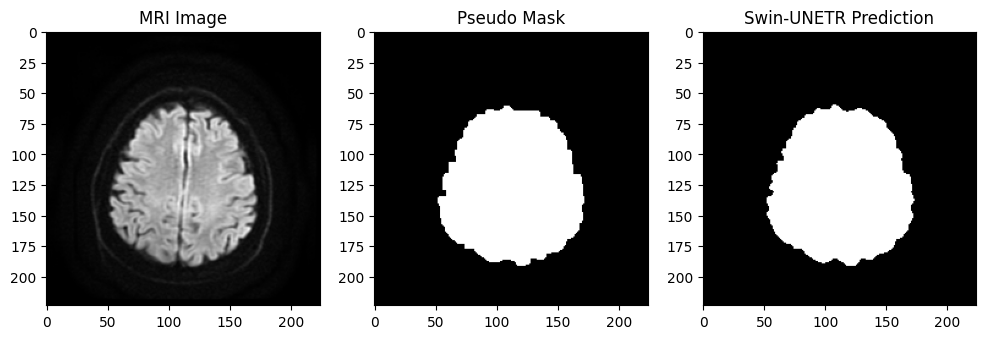

In [16]:
model.eval()

with torch.no_grad():
    img, mask = dataset[0]
    img = img.unsqueeze(0).to(DEVICE)

    pred = torch.sigmoid(model(img))
    pred = pred.cpu().numpy()[0, 0] > 0.5

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("MRI Image")
plt.imshow(img.cpu()[0,0], cmap="gray")

plt.subplot(1,3,2)
plt.title("Pseudo Mask")
plt.imshow(mask[0], cmap="gray")

plt.subplot(1,3,3)
plt.title("Swin-UNETR Prediction")
plt.imshow(pred, cmap="gray")

plt.show()


In [ ]:
torch.save(model.state_dict(), "swin_unetr_mri_weakly_supervised.pth")
print("✅ Model saved successfully")
